### Python Code

In [2]:
# import libraries
import pandas as pd
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
import matplotlib.pyplot as plt

c:\Users\mftok\OneDrive\Github\mftokic.github.io\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# read data
data_raw = pd.read_csv("../posts/2024-10-02-ts-fundamentals-whats-a-time-series/example_ts_data.csv")

data_raw = (
    # select columns
    data_raw[["Country", "Product", "Date", "Revenue"]]
    # change data types
    .assign(
        Date = pd.to_datetime(data_raw["Date"]), 
        Revenue = pd.to_numeric(data_raw["Revenue"])
    )
)

# print the first few rows
print(data_raw.head())

         Country    Product       Date  Revenue
0  United States  Ice Cream 2019-01-01       10
1  United States  Ice Cream 2019-02-01       12
2  United States  Ice Cream 2019-03-01       15
3  United States  Ice Cream 2019-04-01        9
4  United States  Ice Cream 2019-05-01       11


C:\Users\mftok\AppData\Local\Temp\ipykernel_3424\2972639449.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  us_ic_raw["unique_id"] = us_ic_raw["Country"] + "_" + us_ic_raw["Product"]
C:\Users\mftok\AppData\Local\Temp\ipykernel_3424\2972639449.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  us_ic_raw["Date"] = pd.to_datetime(us_ic_raw["Date"])


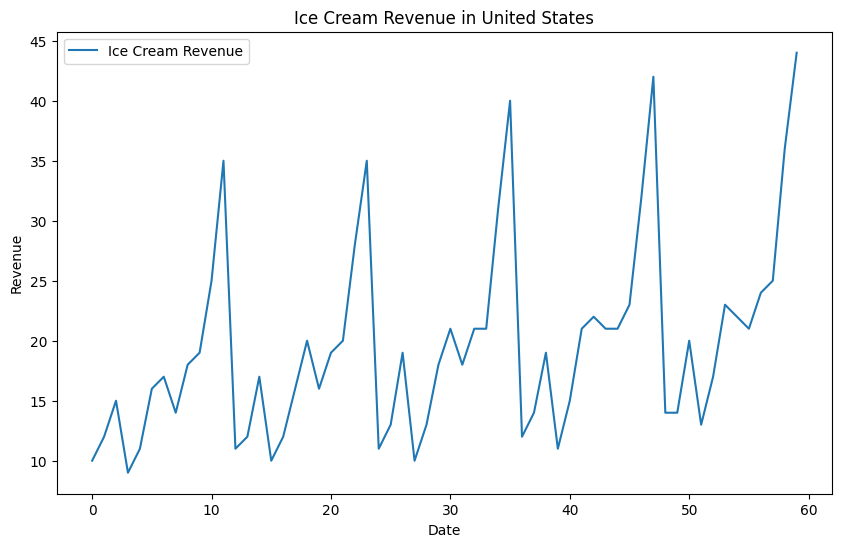

In [4]:
# filter on specific series
us_ic_raw = data_raw[(data_raw["Country"] == "United States") & (data_raw["Product"] == "Ice Cream")]

# create unique id
us_ic_raw["unique_id"] = us_ic_raw["Country"] + "_" + us_ic_raw["Product"]

# convert date to datetime
us_ic_raw["Date"] = pd.to_datetime(us_ic_raw["Date"])

# plot the data
plt.figure(figsize=(10, 6))
plt.plot(us_ic_raw.index, us_ic_raw["Revenue"], label="Ice Cream Revenue")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.title("Ice Cream Revenue in United States")
plt.legend()

In [5]:
# get final data for forecasting
us_ic_clean = us_ic_raw[["unique_id", "Date", "Revenue"]].copy()

# set up models to train
sf = StatsForecast(
    models=[AutoARIMA(season_length=12)],
    freq='ME',
)

# fit the model and forecast for 12 months ahead
Y_hat_df = sf.forecast(df = us_ic_clean, 
                       time_col = "Date", 
                       target_col = "Revenue", 
                       id_col = "unique_id", 
                       h=12, 
                       level=[95], 
                       fitted=True)

print(Y_hat_df.head())

# convert date to be first of the month
Y_hat_df["Date"] = Y_hat_df["Date"].dt.to_period("M").dt.to_timestamp()

                 unique_id       Date  AutoARIMA  AutoARIMA-lo-95  \
0  United States_Ice Cream 2023-12-31       15.5        13.248834   
1  United States_Ice Cream 2024-01-31       15.5        13.248834   
2  United States_Ice Cream 2024-02-29       21.5        19.248835   
3  United States_Ice Cream 2024-03-31       14.5        12.248834   
4  United States_Ice Cream 2024-04-30       18.5        16.248835   

   AutoARIMA-hi-95  
0        17.751165  
1        17.751165  
2        23.751165  
3        16.751165  
4        20.751165  


In [6]:
# concat both df together
future_fcst_df = pd.concat([us_ic_clean, Y_hat_df], axis=0)

# make date the index
future_fcst_df.set_index("Date", inplace=True)

print(future_fcst_df.tail())

                          unique_id  Revenue  AutoARIMA  AutoARIMA-lo-95  \
Date                                                                       
2024-07-01  United States_Ice Cream      NaN       22.5        20.248835   
2024-08-01  United States_Ice Cream      NaN       25.5        23.248835   
2024-09-01  United States_Ice Cream      NaN       26.5        24.248835   
2024-10-01  United States_Ice Cream      NaN       37.5        35.248833   
2024-11-01  United States_Ice Cream      NaN       45.5        43.248833   

            AutoARIMA-hi-95  
Date                         
2024-07-01        24.751165  
2024-08-01        27.751165  
2024-09-01        28.751165  
2024-10-01        39.751167  
2024-11-01        47.751167  


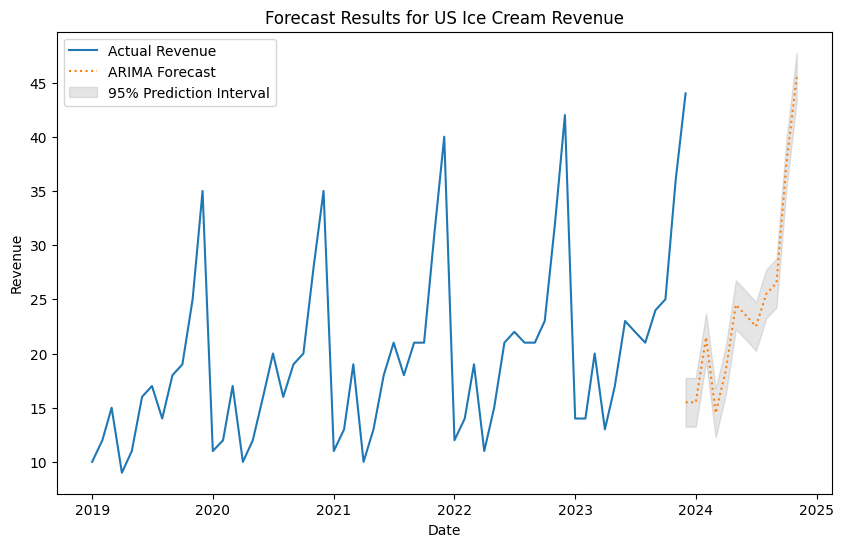

In [7]:
# plot the future fcst data
plt.figure(figsize=(10, 6))

# plot the original revenue data as line and forecast as dotted line
plt.plot(future_fcst_df.index, future_fcst_df["Revenue"], label="Actual Revenue")
plt.plot(future_fcst_df.index, future_fcst_df["AutoARIMA"], label="ARIMA Forecast", linestyle='dotted')

# plot the prediction intervals as shaded areas
plt.fill_between(future_fcst_df.index, 
                 future_fcst_df["AutoARIMA-lo-95"], 
                 future_fcst_df["AutoARIMA-hi-95"], 
                 color='gray', alpha=0.2, label='95% Prediction Interval')

# chart formatting
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.title("Forecast Results for US Ice Cream Revenue")
plt.legend()

# save the plot
# plt.savefig("chart1", dpi = 300, bbox_inches = "tight")

In [8]:
# get fitted values of the historical data
# Note: The fitted values are the predicted values for the training data
residual_values = sf.forecast_fitted_values()

# make date the index
residual_values.set_index("Date", inplace=True)

print(residual_values.head())

                          unique_id  Revenue  AutoARIMA  AutoARIMA-lo-95  \
Date                                                                       
2019-01-01  United States_Ice Cream     10.0   9.990125         7.738959   
2019-02-01  United States_Ice Cream     12.0  11.988250         9.737084   
2019-03-01  United States_Ice Cream     15.0  14.985375        12.734209   
2019-04-01  United States_Ice Cream      9.0   8.991500         6.740334   
2019-05-01  United States_Ice Cream     11.0  10.989625         8.738459   

            AutoARIMA-hi-95  
Date                         
2019-01-01        12.241291  
2019-02-01        14.239416  
2019-03-01        17.236542  
2019-04-01        11.242666  
2019-05-01        13.240791  


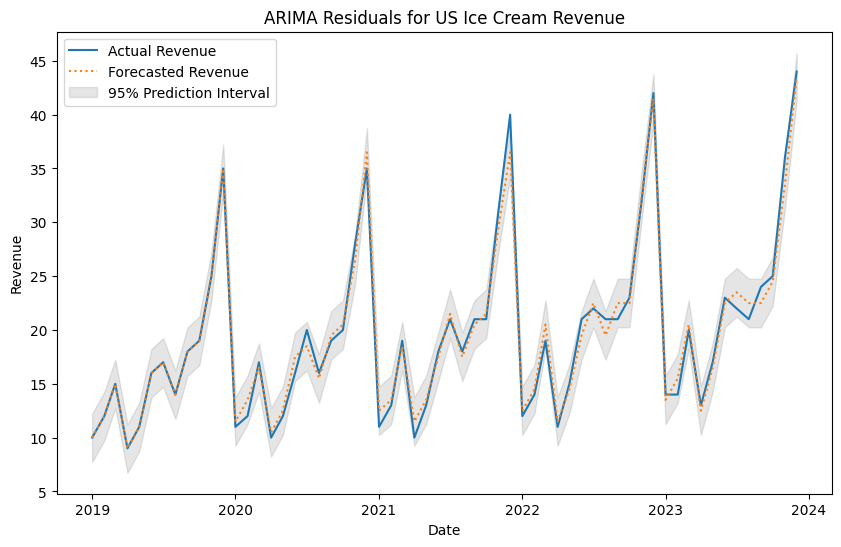

In [9]:
# plot the historical fitted values
plt.figure(figsize=(10, 6))

# plot the original revenue data as line and forecast as dotted line
plt.plot(residual_values.index, residual_values["Revenue"], label="Actual Revenue")
plt.plot(residual_values.index, residual_values["AutoARIMA"], label="Forecasted Revenue", linestyle='dotted')

# plot the prediction intervals as shaded areas
plt.fill_between(residual_values.index, 
                 residual_values["AutoARIMA-lo-95"], 
                 residual_values["AutoARIMA-hi-95"], 
                 color='gray', alpha=0.2, label='95% Prediction Interval')

# chart formatting
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.title("ARIMA Residuals for US Ice Cream Revenue")
plt.legend()

# save the plot
# plt.savefig("chart2", dpi = 300, bbox_inches = "tight")

Text(0.5, 1.0, 'Residuals Over Time')

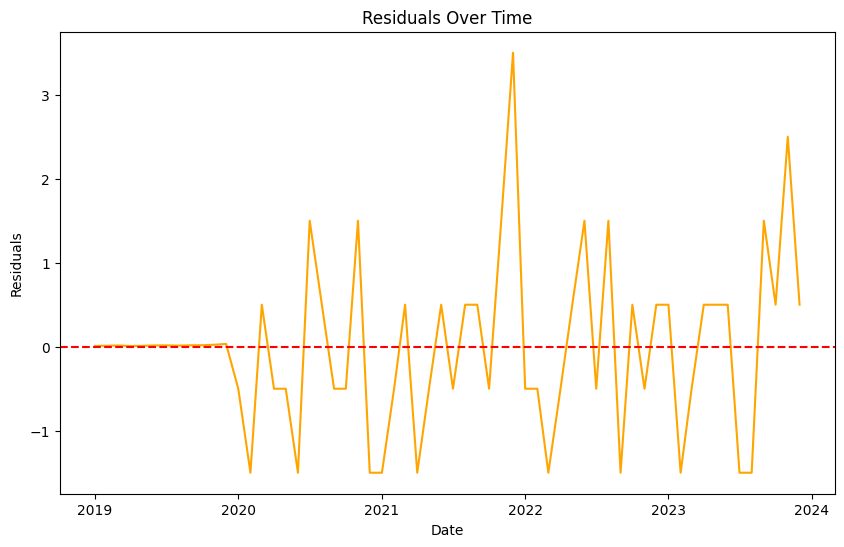

In [10]:
# calculate residuals and plot the residuals directly as a line chart 
residuals = residual_values["Revenue"] - residual_values["AutoARIMA"]

plt.figure(figsize=(10, 6))
plt.plot(residuals.index, residuals, label="Residuals", color='orange')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Date")
plt.ylabel("Residuals")
plt.title("Residuals Over Time")

# save the plot
# plt.savefig("chart3", dpi = 300, bbox_inches = "tight")

Text(0.5, 1.0, 'Histogram of Residuals')

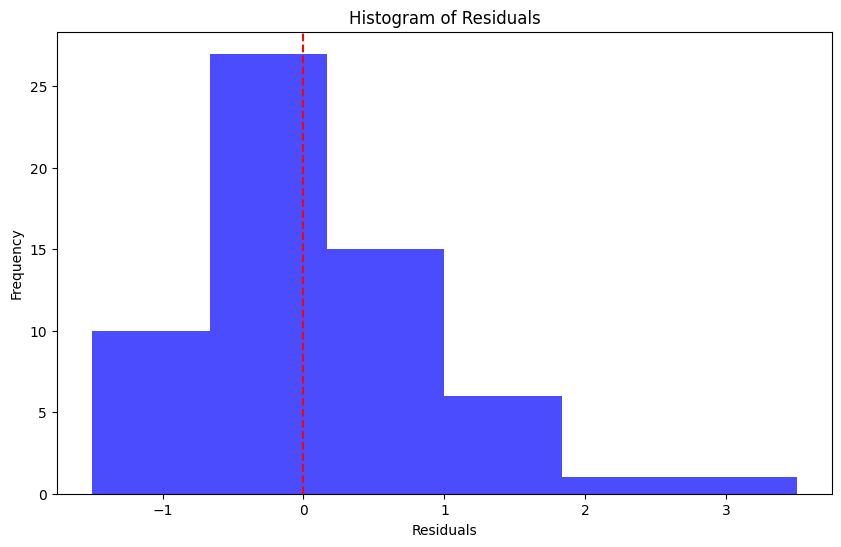

In [11]:
# create histogram of residuals
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=6, color='blue', alpha=0.7)
plt.axvline(x=0, color='red', linestyle='--')
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")

# save the plot
# plt.savefig("chart4", dpi = 300, bbox_inches = "tight")

Text(0.5, 1.0, 'Q-Q Plot of Actual vs Fitted Values')

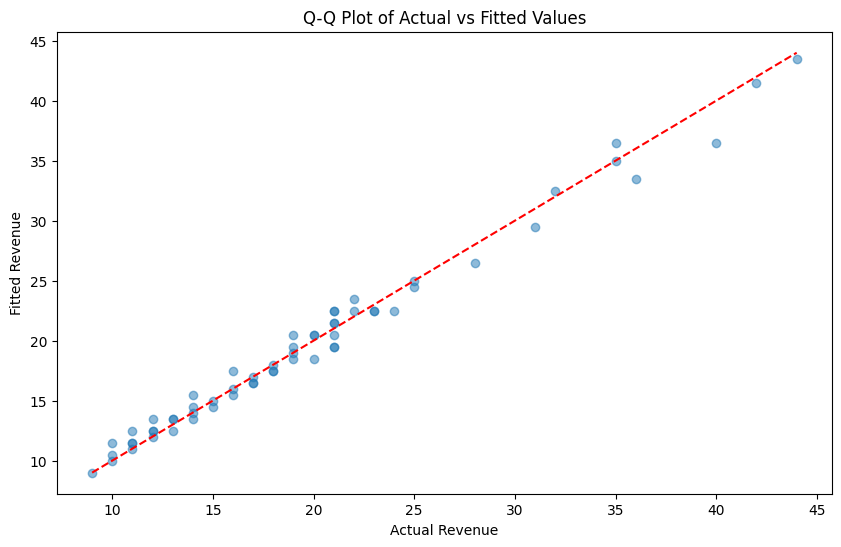

In [12]:
# create chart that puts the actual values on one side and the fitted values on the other as a scatter plot
plt.figure(figsize=(10, 6))
# plot the actual values
plt.scatter(residual_values["Revenue"], residual_values["AutoARIMA"], label="Fitted Values", alpha=0.5)
# plot the 45 degree line
plt.plot([residual_values["Revenue"].min(), residual_values["Revenue"].max()], 
         [residual_values["Revenue"].min(), residual_values["Revenue"].max()], 
         color='red', linestyle='--', label="45 Degree Line")
# chart formatting
plt.xlabel("Actual Revenue")
plt.ylabel("Fitted Revenue")
plt.title("Q-Q Plot of Actual vs Fitted Values")

# save the plot
# plt.savefig("chart5", dpi = 300, bbox_inches = "tight")

C:\Users\mftok\AppData\Local\Temp\ipykernel_3424\3336845809.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


<Figure size 1000x600 with 0 Axes>

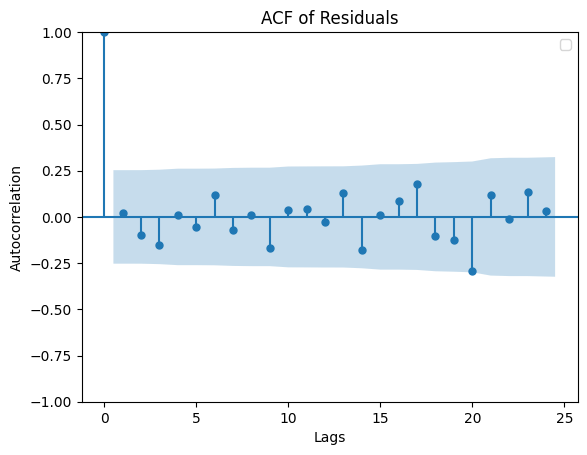

In [13]:
# create ACF plot on the residuals
from statsmodels.graphics.tsaplots import plot_acf
plt.figure(figsize=(10, 6))
plot_acf(residuals, lags=24)
plt.title("ACF of Residuals")
plt.xlabel("Lags")
plt.ylabel("Autocorrelation")
plt.legend()

# save the plot
# plt.savefig("chart6", dpi = 300, bbox_inches = "tight")

In [19]:
# create 
train_test_wrong = us_ic_clean.copy()

